Liczba wszystkich par plików: 1352
Liczba par treningowych: 1094
Liczba par walidacyjnych: 122
Liczba par testowych: 136


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name        | Type                      | Params | Mode 
-------------------------------------------------------------------
0  | initial     | Sequential                | 3.3 K  | train
1  | maxpool     | MaxPool2d                 | 0      | train
2  | layer1      | Sequential                | 221 K  | train
3  | layer2      | Sequential                | 1.1 M  | train
4  | layer3      | Sequential                | 6.8 M  | train
5  | layer4      | Sequential                | 13.1 M | train
6  | upconv4     | ConvTranspose2d 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

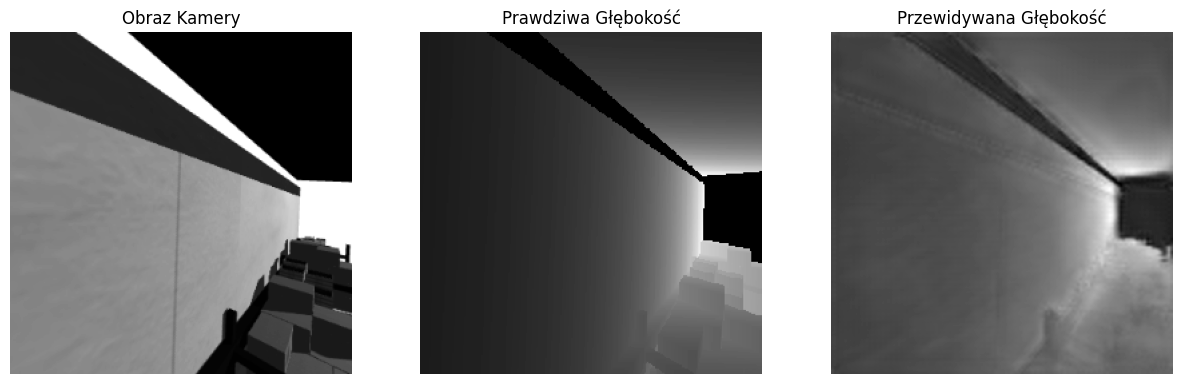

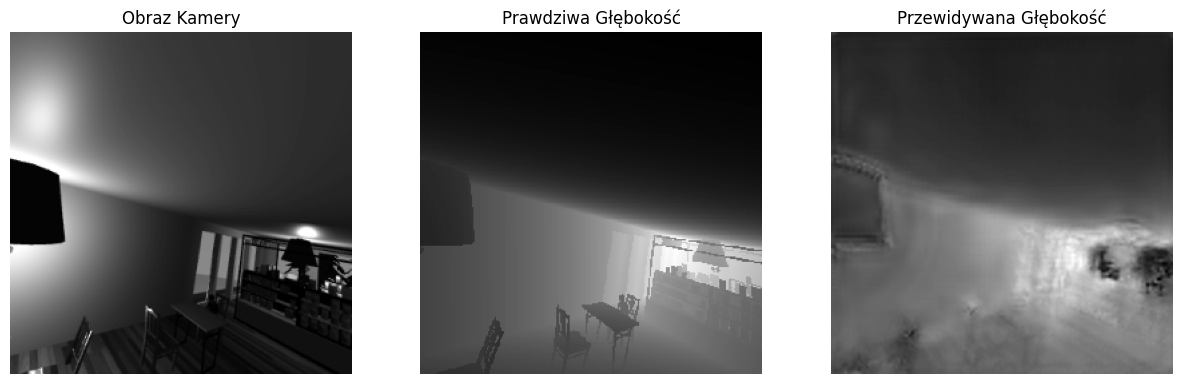

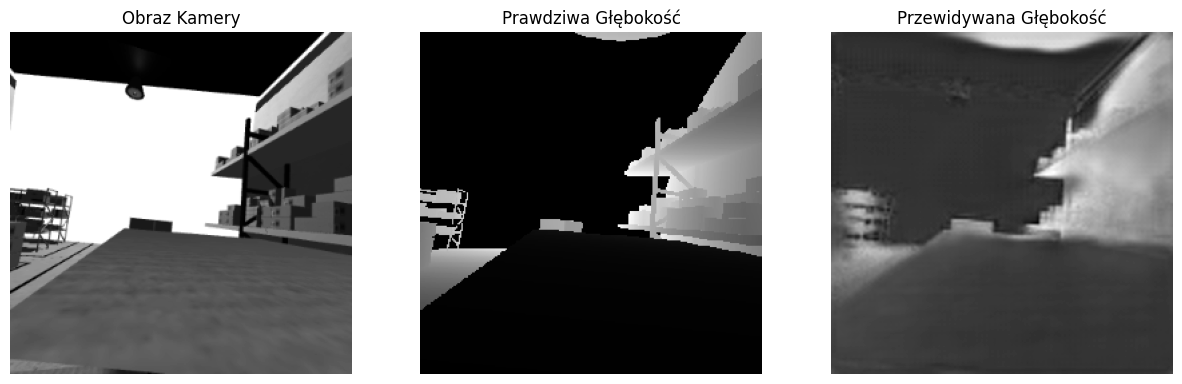

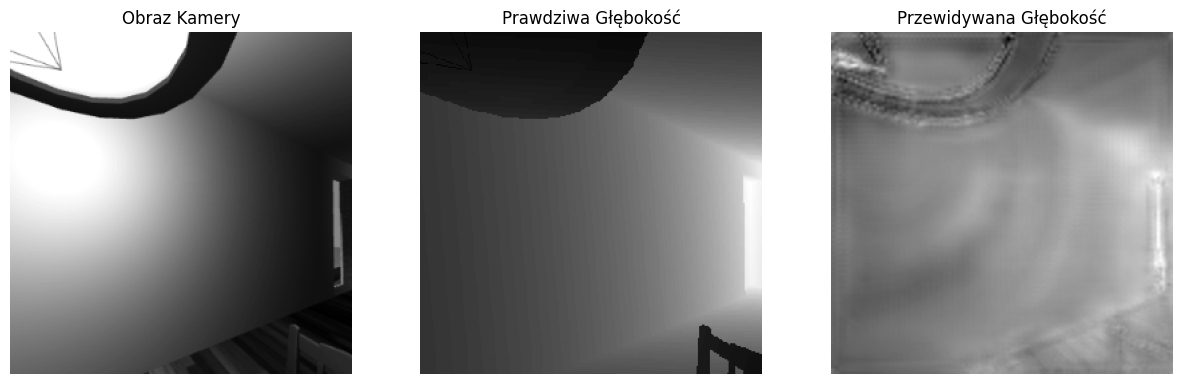

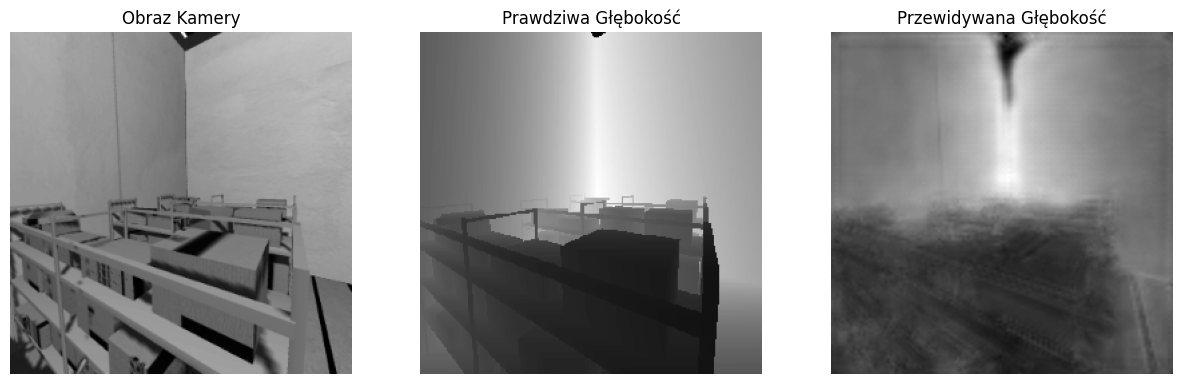

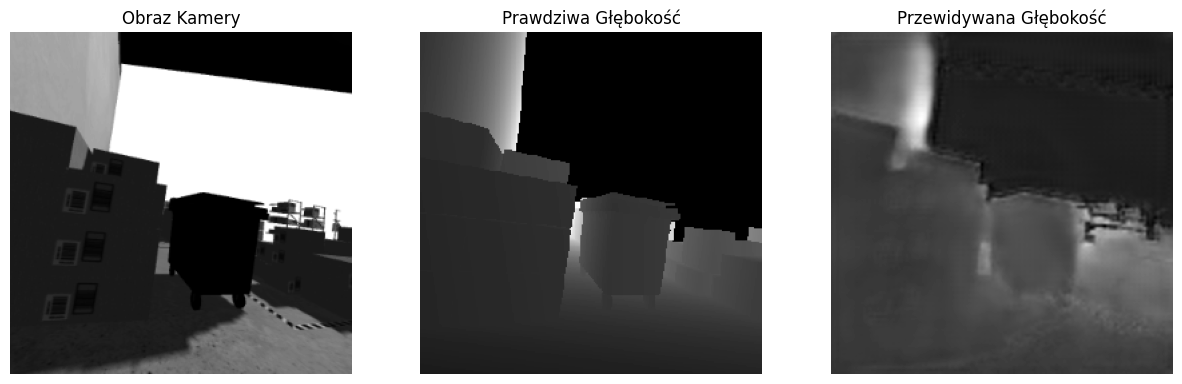

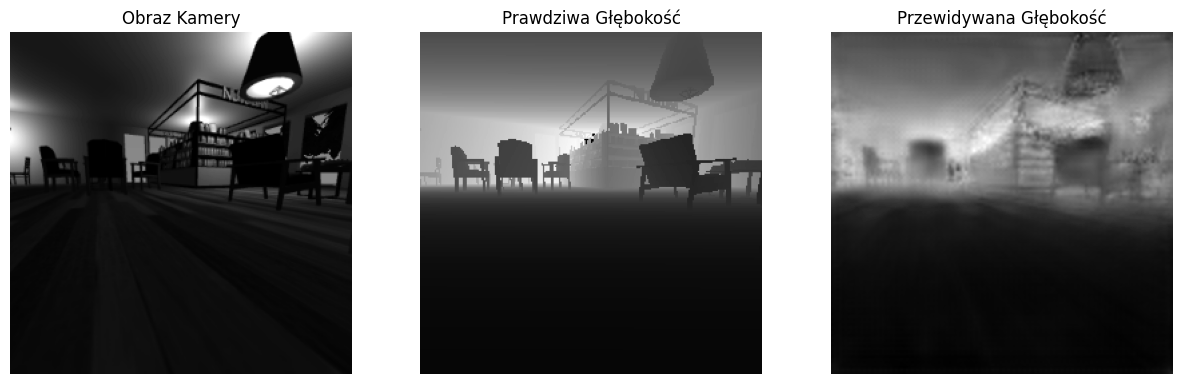

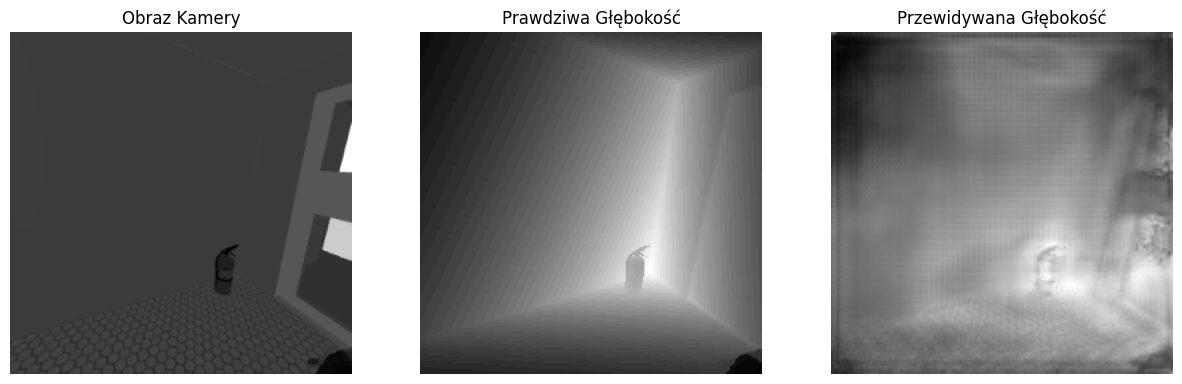

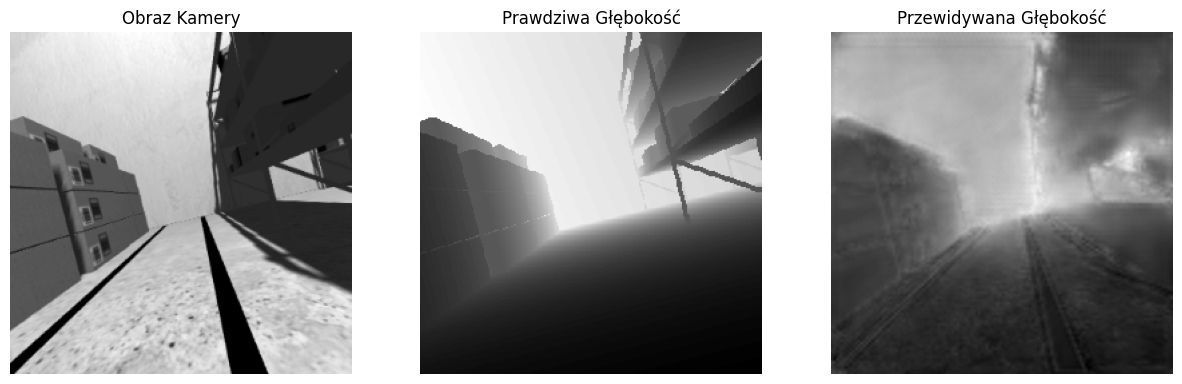

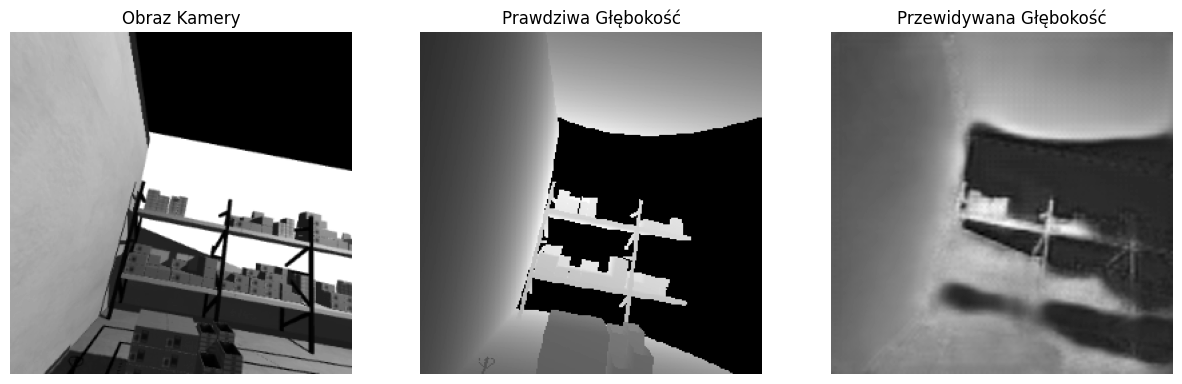

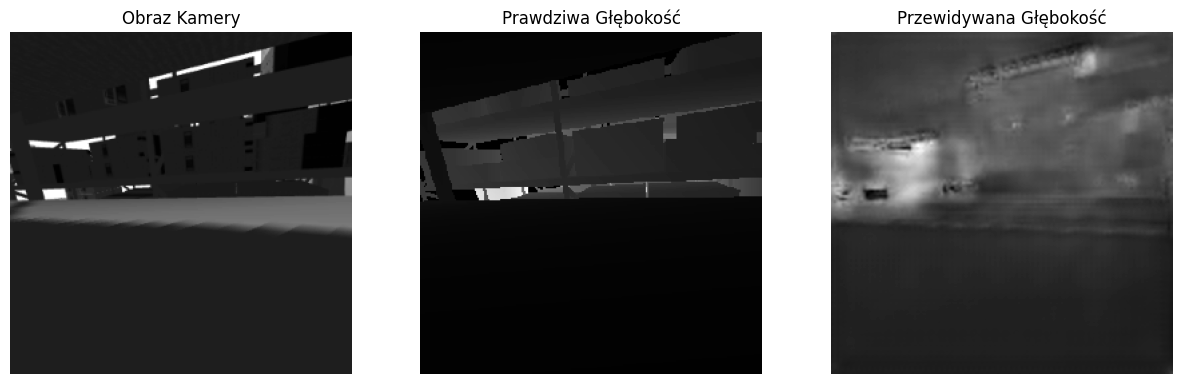

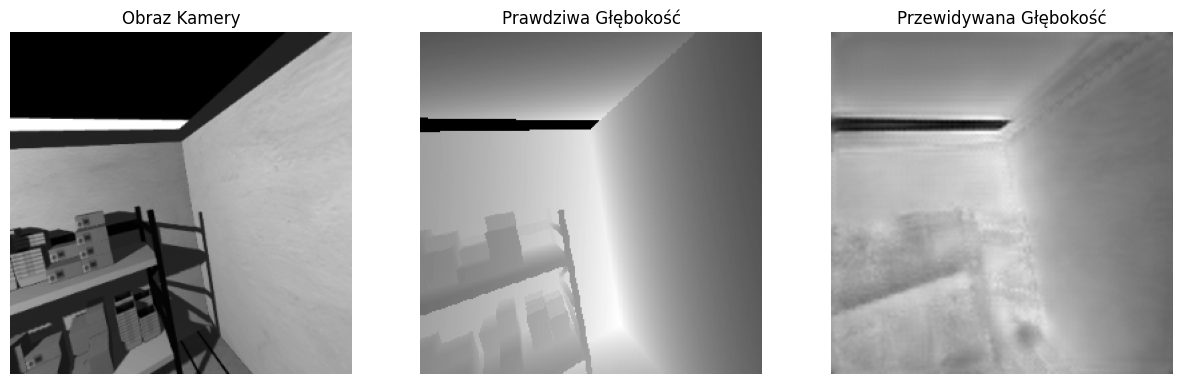

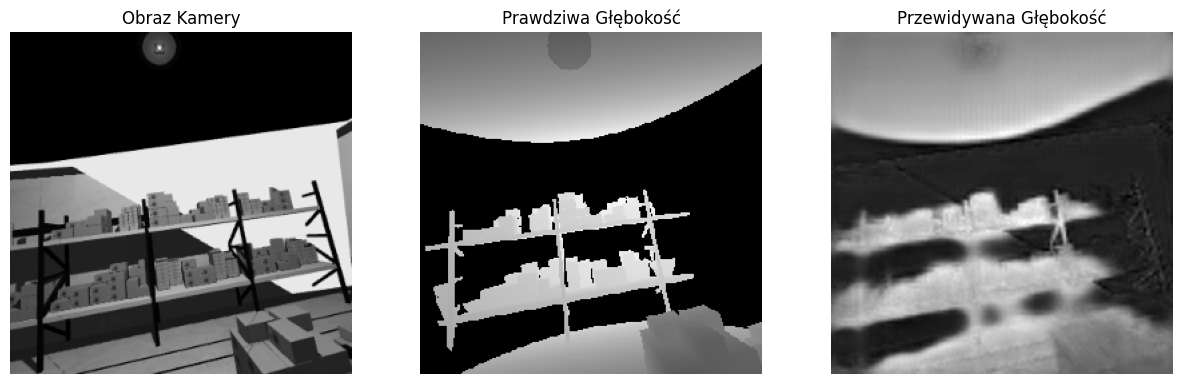

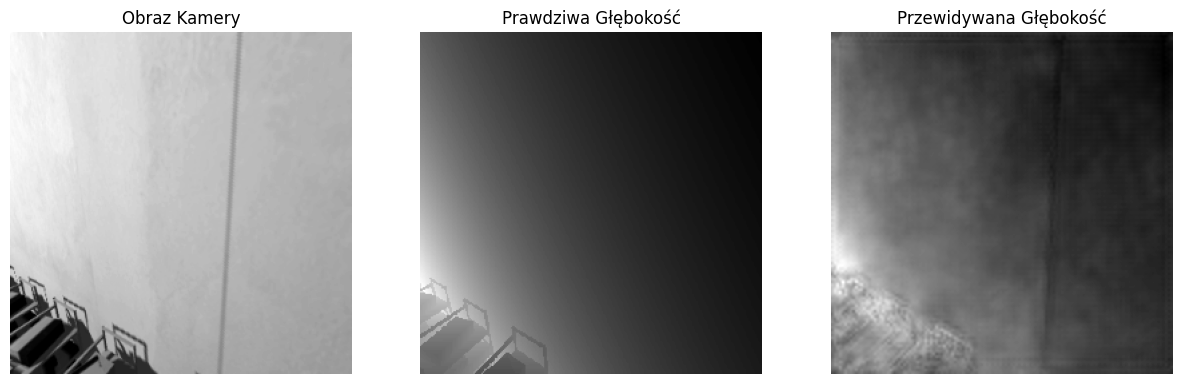

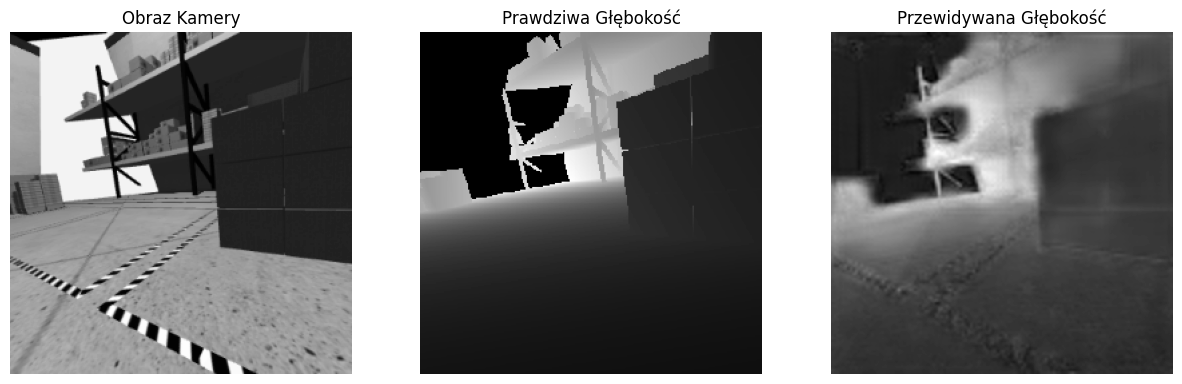

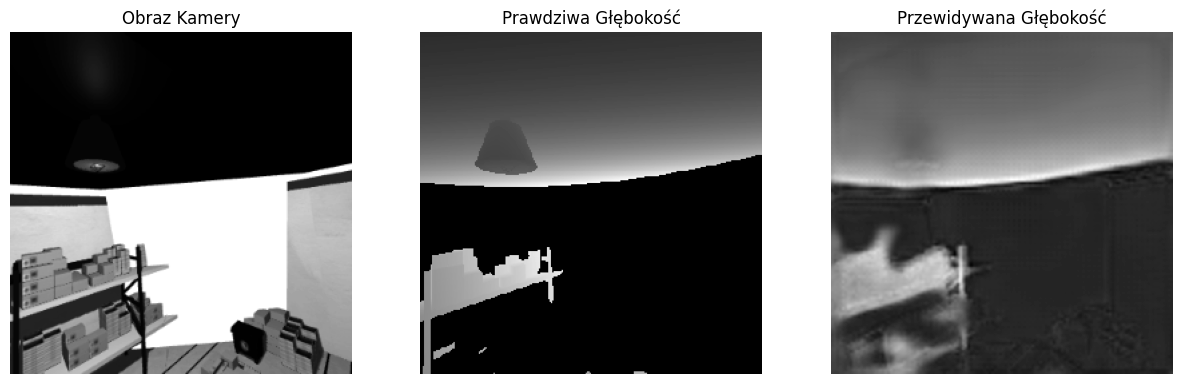

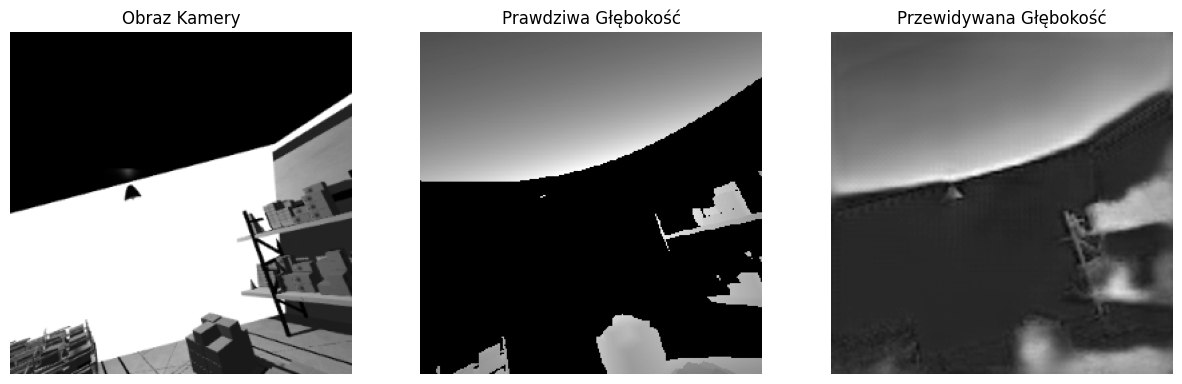

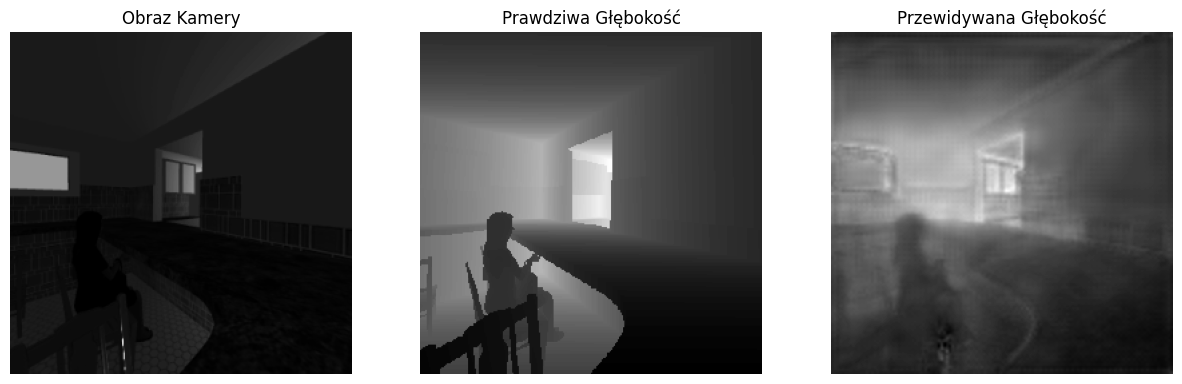

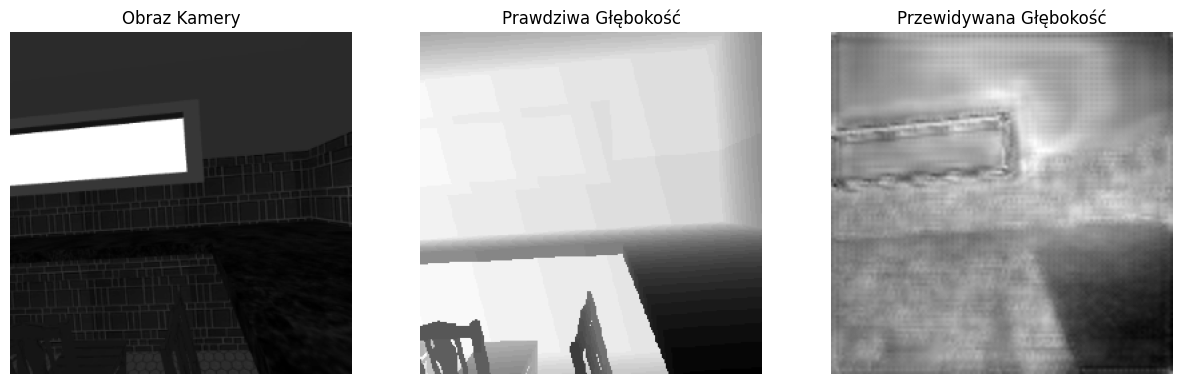

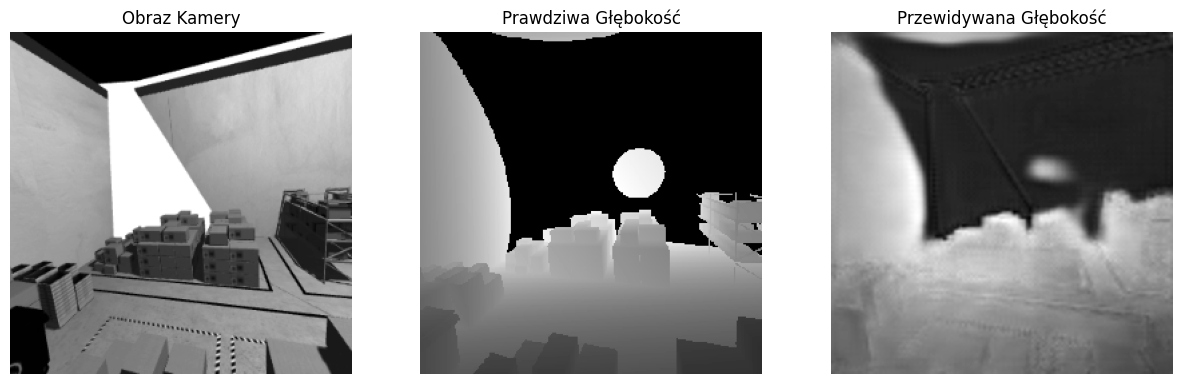

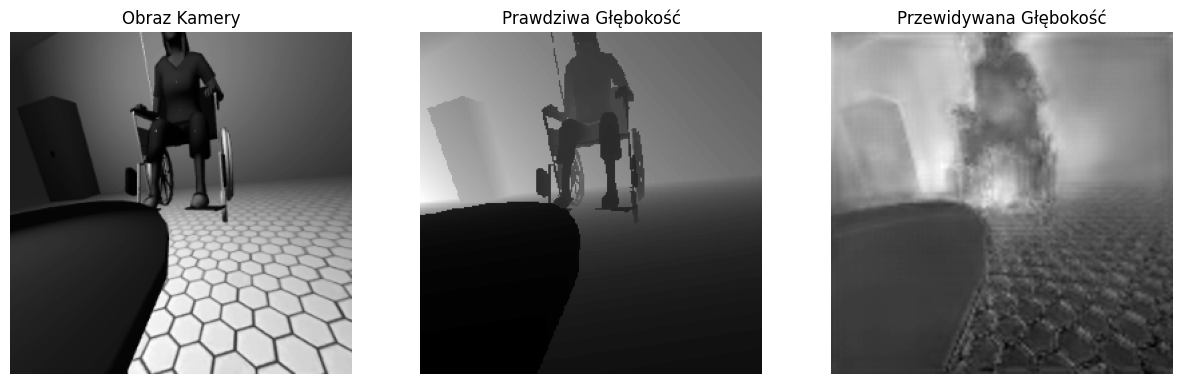

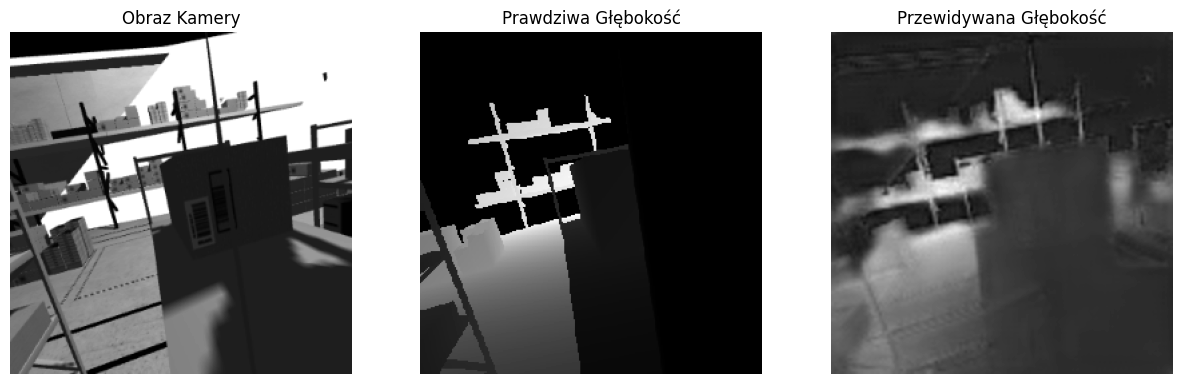

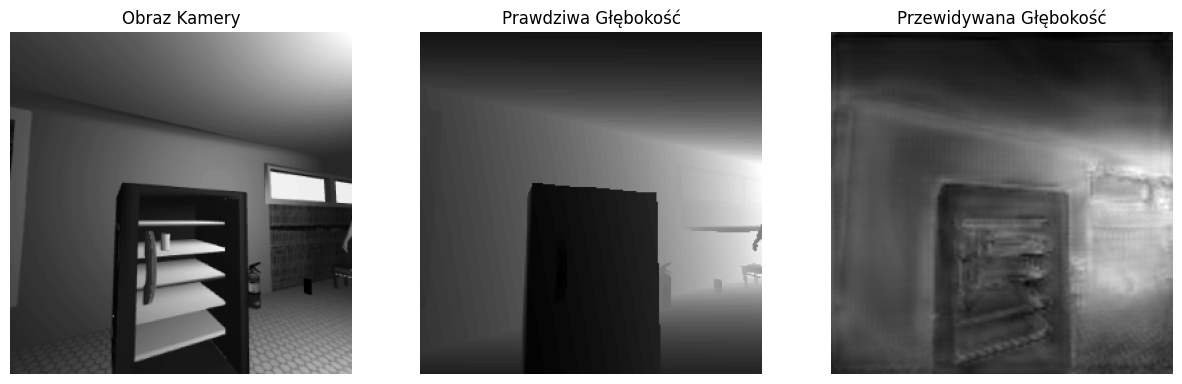

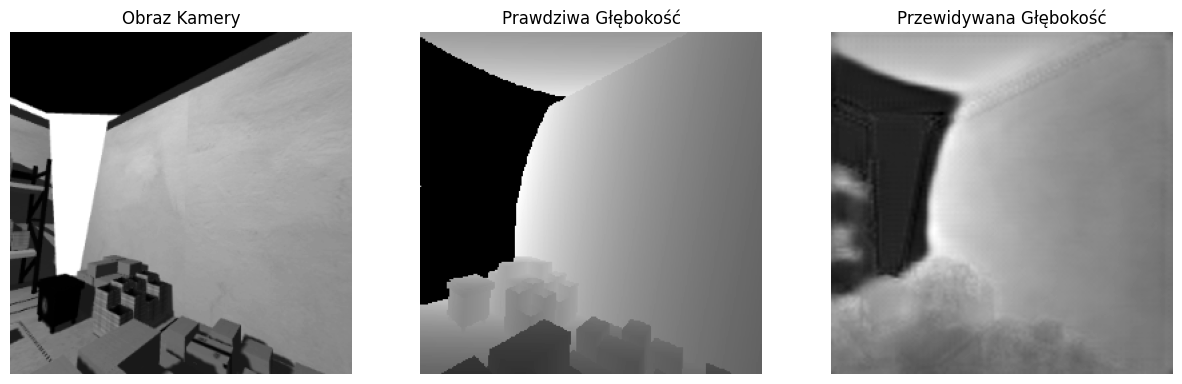

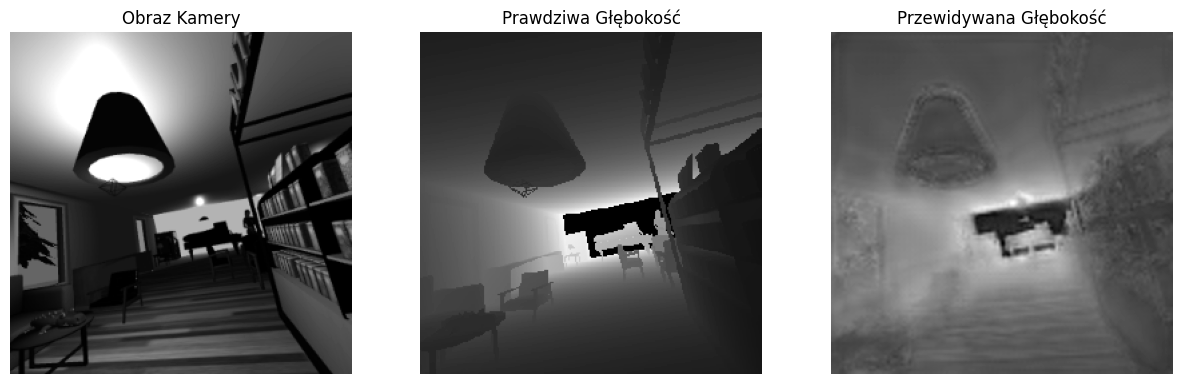

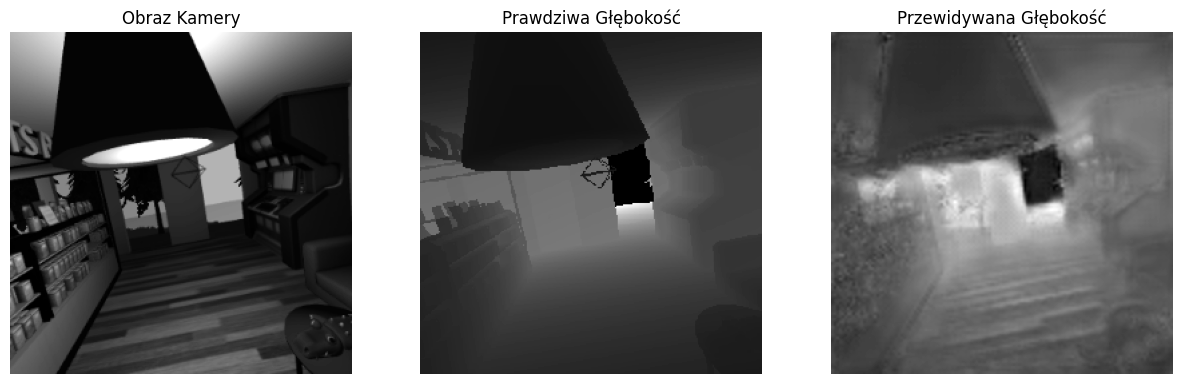

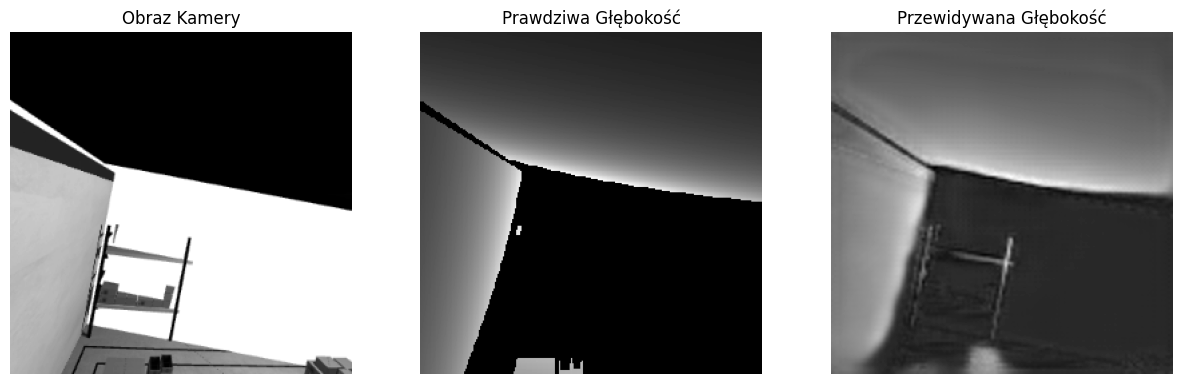

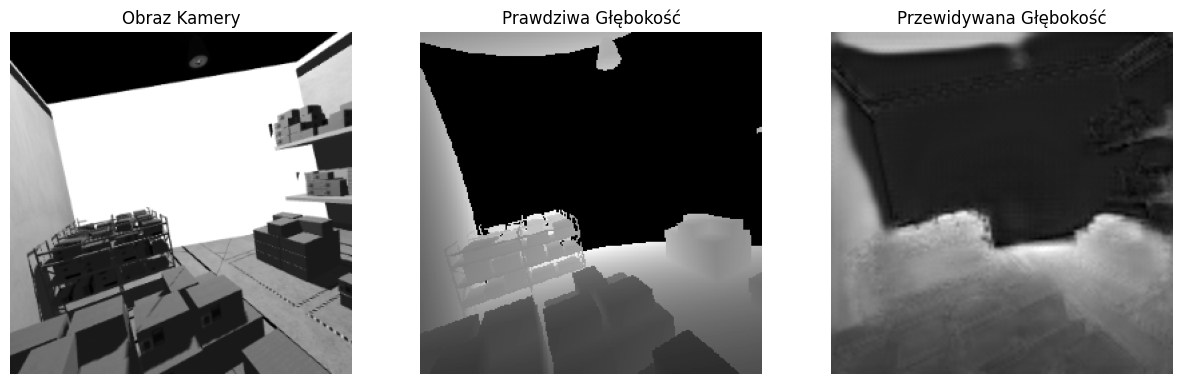

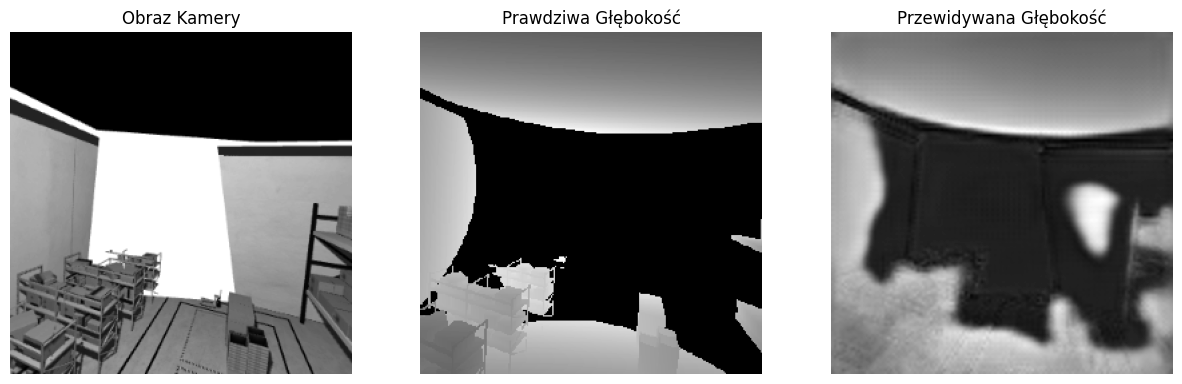

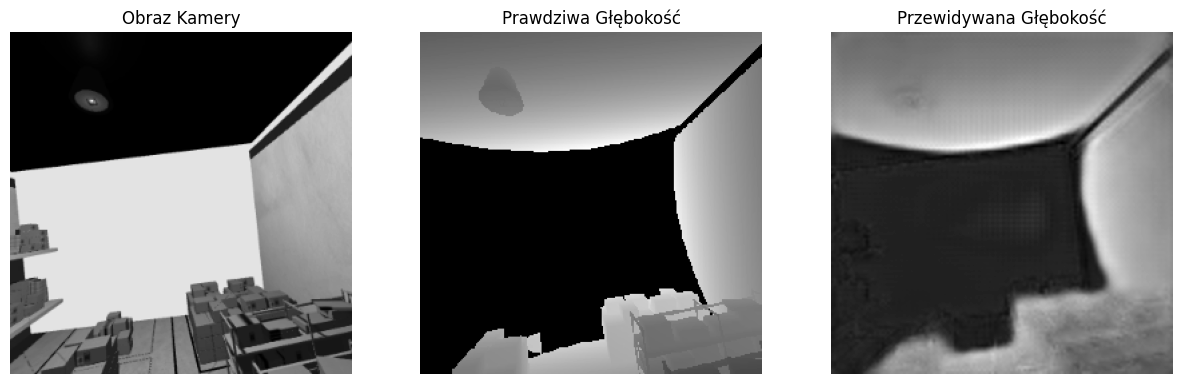

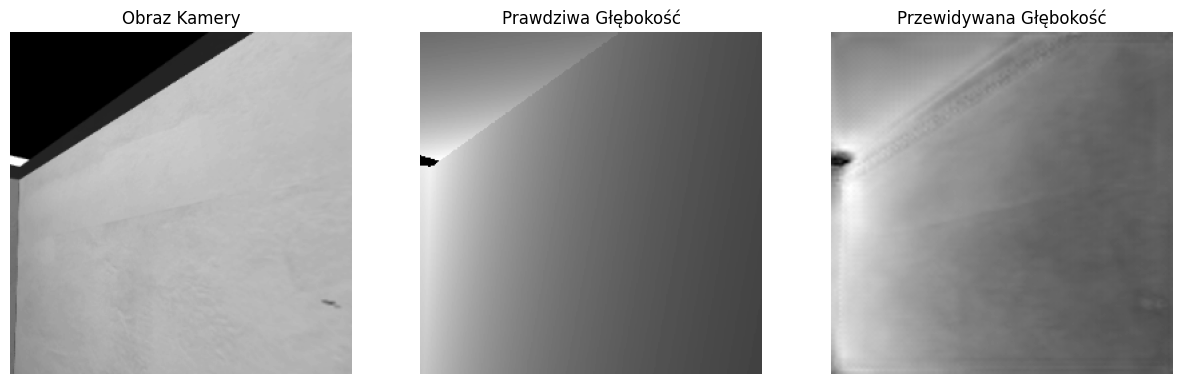

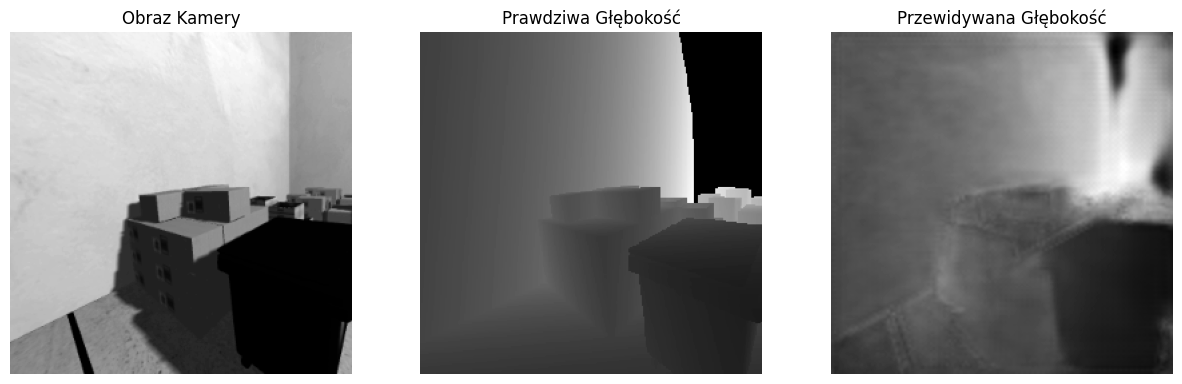

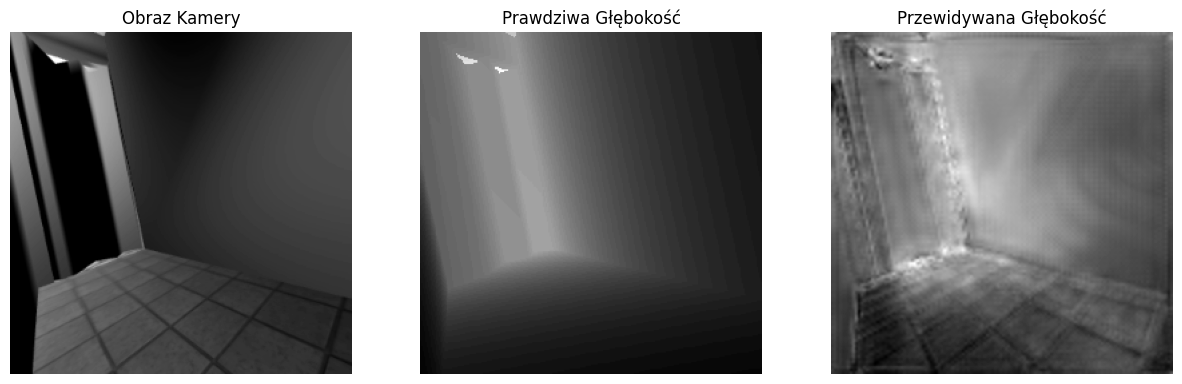

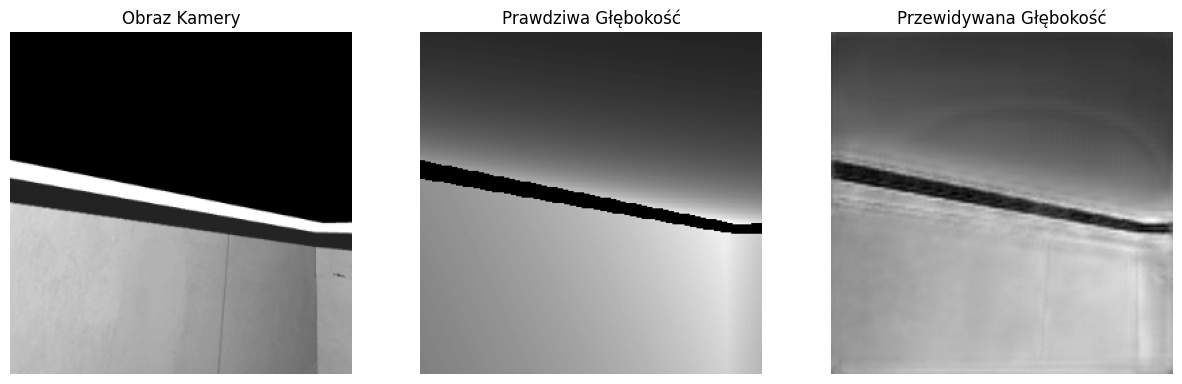

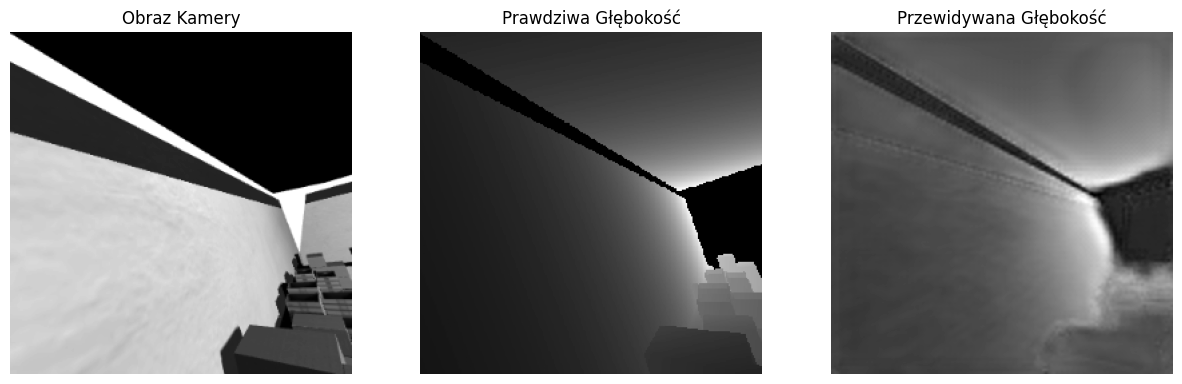

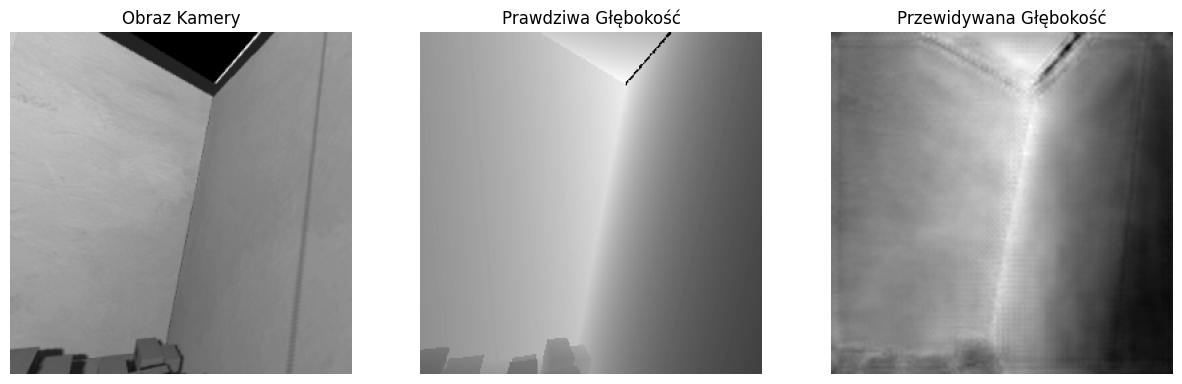

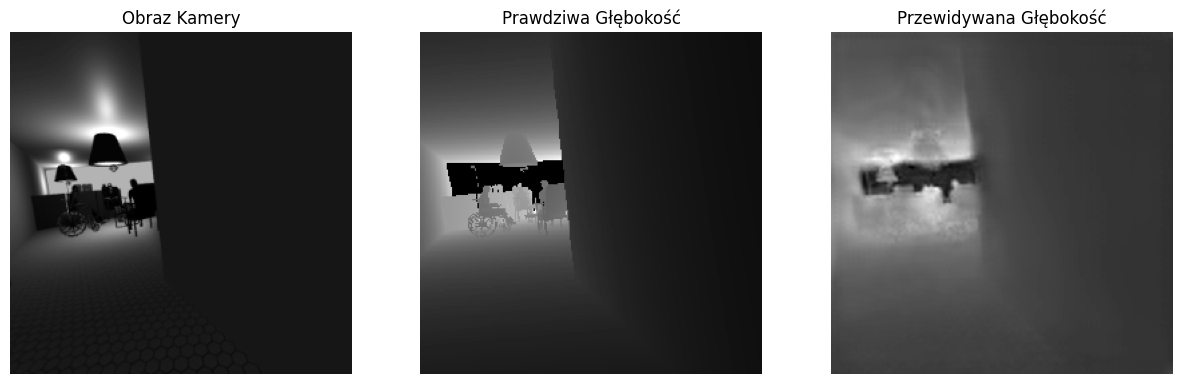

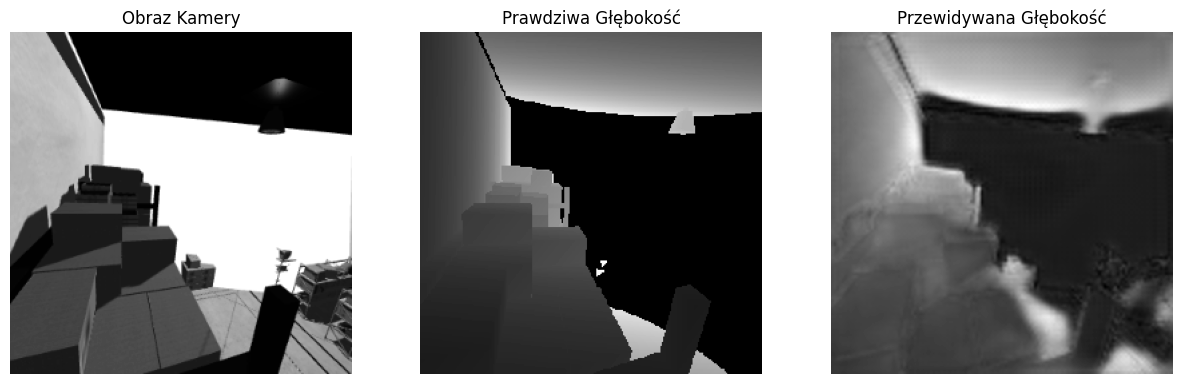

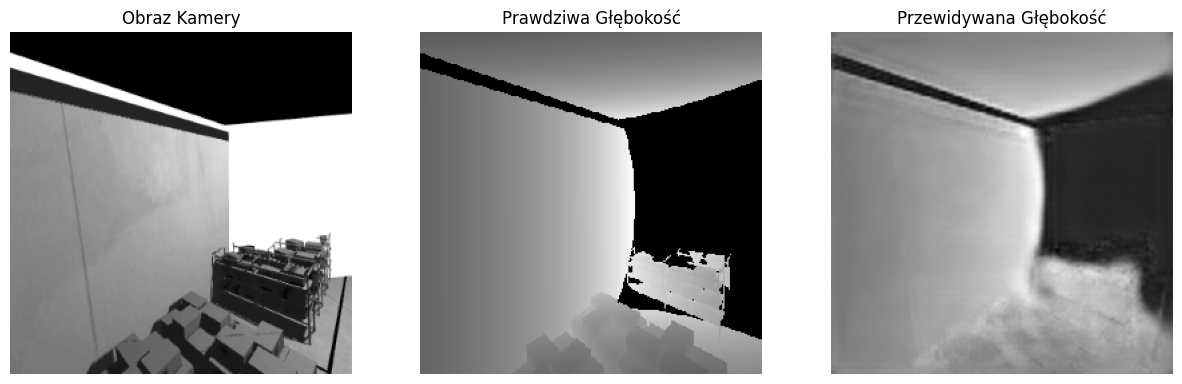

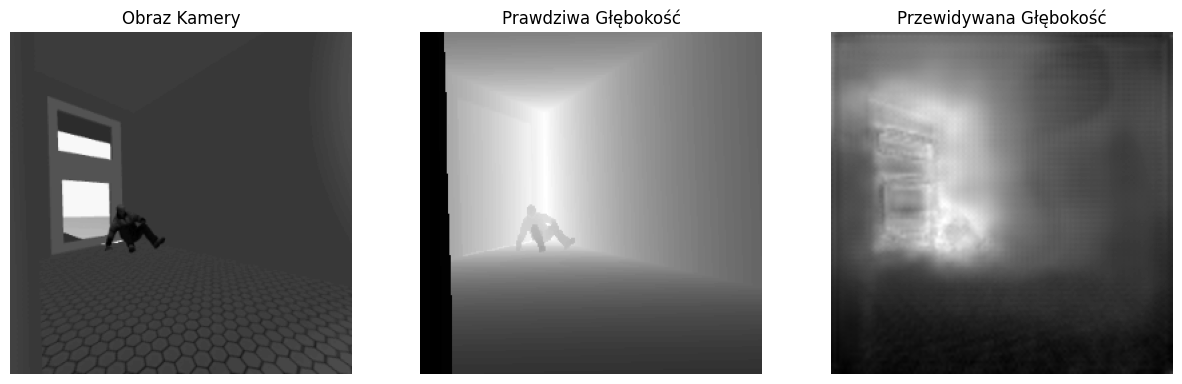

In [ ]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from albumentations import Compose, Resize, HorizontalFlip
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.models as models


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        weight = self.fc(x)
        return x * weight

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        # Spatial Attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca_weight = self.channel_attention(x)
        x = x * ca_weight
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa_weight = self.spatial_attention(torch.cat([avg_out, max_out], dim=1))
        return x * sa_weight


class DecoderBlockWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels, attention='cbam'):
        super(DecoderBlockWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if attention == 'cbam':
            self.attention = CBAM(out_channels)
        elif attention == 'se':
            self.attention = SEBlock(out_channels)
        else:
            self.attention = None

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.attention:
            x = self.attention(x)

        x = self.relu(x)
        return x


class UNetWithPretrainedEncoder(pl.LightningModule):
    def __init__(self, input_channels=1, learning_rate=1e-4, attention_type='cbam', target_size=(256,256)):
        super(UNetWithPretrainedEncoder, self).__init__()
        self.learning_rate = learning_rate
        self.target_size = target_size
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        if input_channels != 3:
            old_weight = resnet.conv1.weight.data
            resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            with torch.no_grad():
                resnet.conv1.weight[:,0:1] = old_weight.mean(dim=1, keepdim=True)

        self.initial = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1  # 64, 64x64
        self.layer2 = resnet.layer2  # 128, 32x32
        self.layer3 = resnet.layer3  # 256, 16x16
        self.layer4 = resnet.layer4  # 512, 8x8

        # Dekoder
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = DecoderBlockWithAttention(512, 256, attention=attention_type)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = DecoderBlockWithAttention(256, 128, attention=attention_type)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = DecoderBlockWithAttention(128, 64, attention=attention_type)

        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.decoder1 = DecoderBlockWithAttention(128, 64, attention=attention_type)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

        # Metryki
        self.rmse_metric = torchmetrics.MeanSquaredError(squared=False)
        self.mae_metric = torchmetrics.MeanAbsoluteError()
        self.criterion = nn.SmoothL1Loss()

    def forward(self, x):
        x = nn.functional.interpolate(x, size=self.target_size)
        # Enkoder
        x0 = self.initial(x)   # [B,64,128,128]
        x1 = self.maxpool(x0)  # [B,64,64,64]
        x2 = self.layer1(x1)   # [B,64,64,64]
        x3 = self.layer2(x2)   # [B,128,32,32]
        x4 = self.layer3(x3)   # [B,256,16,16]
        x5 = self.layer4(x4)   # [B,512,8,8]

        # Dekoder
        d4 = self.upconv4(x5)           # [B,256,16,16]
        d4 = torch.cat([d4, x4], dim=1) # [B,512,16,16]
        d4 = self.decoder4(d4)          # [B,256,16,16]

        d3 = self.upconv3(d4)           # [B,128,32,32]
        d3 = torch.cat([d3, x3], dim=1) # [B,256,32,32]
        d3 = self.decoder3(d3)          # [B,128,32,32]

        d2 = self.upconv2(d3)           # [B,64,64,64]
        d2 = torch.cat([d2, x2], dim=1) # [B,128,64,64]
        d2 = self.decoder2(d2)          # [B,64,64,64]

        d1 = self.upconv1(d2)           # [B,64,128,128]
        d1 = torch.cat([d1, x0], dim=1) # [B,128,128,128] zamiast x1 dajemy x0
        d1 = self.decoder1(d1)          # [B,64,128,128]

        out = nn.functional.interpolate(d1, size=self.target_size, mode='bilinear', align_corners=False)
        out = self.final_conv(out) # [B,1,256,256]

        return out

    def training_step(self, batch, batch_idx):
        images, depths = batch
        preds = self.forward(images)
        loss = self.criterion(preds, depths)
        rmse = self.rmse_metric(preds, depths)
        mae = self.mae_metric(preds, depths)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_rmse", rmse, prog_bar=True)
        self.log("train_mae", mae, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, depths = batch
        preds = self.forward(images)
        loss = self.criterion(preds, depths)
        rmse = self.rmse_metric(preds, depths)
        mae = self.mae_metric(preds, depths)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_rmse", rmse, prog_bar=True)
        self.log("val_mae", mae, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5),
            "monitor": "val_loss"
        }
        return [optimizer], [scheduler]


class DepthDataset(Dataset):
    def __init__(self, file_pairs, augment=False, target_size=(256, 256)):
        self.file_pairs = file_pairs
        self.augment = augment
        self.target_size = target_size
        transforms = [
            Resize(self.target_size[0], self.target_size[1]),
        ]
        if self.augment:
            transforms.extend([
                HorizontalFlip(p=0.2)
            ])
        self.transform = Compose(transforms)

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        camera_path, depth_path = self.file_pairs[idx]
        camera_image = cv2.imread(camera_path, cv2.IMREAD_GRAYSCALE)
        depth_image = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
        if camera_image is None:
            raise FileNotFoundError(f"Nie można załadować obrazu kamery: {camera_path}")
        if depth_image is None:
            raise FileNotFoundError(f"Nie można załadować obrazu głębokości: {depth_path}")
        augmented = self.transform(image=camera_image, mask=depth_image)
        camera_image = torch.tensor(augmented['image'], dtype=torch.float32) / 255.0
        depth_image = torch.tensor(augmented['mask'], dtype=torch.float32) / 255.0
        return camera_image.unsqueeze(0), depth_image.unsqueeze(0)

def collect_file_pairs(camera_dirs, depth_dirs):
    camera_dict = {}
    depth_dict = {}

    for cam_dir in camera_dirs:
        for cam_file in os.listdir(cam_dir):
            cam_path = os.path.join(cam_dir, cam_file)
            if os.path.isfile(cam_path):
                try:
                    cam_id = cam_file.split("_", 1)[1]
                    camera_dict[cam_id] = cam_path
                except IndexError:
                    print(f"Problem z {cam_file}.")

    for dep_dir in depth_dirs:
        for dep_file in os.listdir(dep_dir):
            dep_path = os.path.join(dep_dir, dep_file)
            if os.path.isfile(dep_path):
                try:
                    dep_id = dep_file.split("_", 1)[1]
                    depth_dict[dep_id] = dep_path
                except IndexError:
                    print(f"Problem z{dep_file}.")

    file_pairs = []
    for cam_id, cam_path in camera_dict.items():
        if cam_id in depth_dict:
            file_pairs.append((cam_path, depth_dict[cam_id]))
        else:
            print(f"Brak pliku głębokości{cam_id}.")
    return file_pairs

camera_dirs = [
    '/content/crazyflie_images/camera'
]
depth_dirs = [
    '/content/crazyflie_images/depth_camera'
]

all_file_pairs = collect_file_pairs(camera_dirs, depth_dirs)
print(f"Liczba wszystkich par plików: {len(all_file_pairs)}")

train_val_pairs, test_pairs = train_test_split(all_file_pairs, test_size=0.1, random_state=42)
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.1, random_state=42)

print(f"Liczba par treningowych: {len(train_pairs)}")
print(f"Liczba par walidacyjnych: {len(val_pairs)}")
print(f"Liczba par testowych: {len(test_pairs)}")

train_dataset = DepthDataset(train_pairs, augment=True, target_size=(256, 256))
val_dataset = DepthDataset(val_pairs, augment=False, target_size=(256, 256))
test_dataset = DepthDataset(test_pairs, augment=False, target_size=(256, 256))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

model = UNetWithPretrainedEncoder(input_channels=1, learning_rate=1e-4, attention_type='cbam')

logger = TensorBoardLogger("logs", name="depth_estimation_transfer_learning_fixed")
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")
checkpoint_callback = ModelCheckpoint(monitor="val_rmse", mode="min", save_top_k=1, filename='best-checkpoint-transfer-fixed')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    precision="16-mixed" if torch.cuda.is_available() else "32",
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping],
    log_every_n_steps=10
)

trainer.fit(model, train_loader, val_loader)

trainer.save_checkpoint("unet_transfer_learning_fixed.ckpt")

trained_model = UNetWithPretrainedEncoder.load_from_checkpoint("unet_transfer_learning_fixed.ckpt")
trained_model.eval()
if torch.cuda.is_available():
    trained_model.cuda()

def evaluate_and_visualize(model, test_loader, device='cpu', num_batches=5):
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (camera_images, depth_images) in enumerate(test_loader):
            camera_images = camera_images.to(device)
            preds = model(camera_images).cpu()
            preds = preds.squeeze().numpy()
            camera_images = camera_images.cpu().squeeze().numpy()
            depth_images = depth_images.cpu().squeeze().numpy()

            if camera_images.ndim == 2:
                camera_images = np.expand_dims(camera_images, 0)
                depth_images = np.expand_dims(depth_images, 0)
                preds = np.expand_dims(preds, 0)

            for i in range(camera_images.shape[0]):
                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Obraz Kamery")
                plt.imshow(camera_images[i], cmap="gray")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.title("Prawdziwa Głębokość")
                plt.imshow(depth_images[i], cmap="gray")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.title("Przewidywana Głębokość")
                plt.imshow(preds[i], cmap="gray")
                plt.axis("off")

                plt.show()

            if batch_idx + 1 >= num_batches:
                break

device = 'cuda' if torch.cuda.is_available() else 'cpu'
evaluate_and_visualize(trained_model, test_loader, device=device, num_batches=5)

In [ ]:
!pip install pytorch-lightning albumentations torchmetrics scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 47.0 MB/s eta 0:00:00
